# Bayesian Network

## Problem
- Explore existing file formats for representing Bayesian networks. Choose any of the formats you like. You can use the existing parsers for networks of the selected file format.   (using pgmpy to load the network) ✔

- Implement two Bayesian probability inference algorithms, which will answers to requests for any subset of variables. For example of the form P(A = ai & B = bj & D = dk), note that C is missing. The first algorithm should calculate the exact answer. The second algorithm should use random sampling to calculate the required probability. (exactly implemented like this) ✔

- For several queries, calculate the probability using both algorithms. For the second algorithm plot dependence of current probability on number sampled instances. ✔
    - Estimated prob over time
    - Comparison between probability distributions of events for both methods (They should match) 
    - Comparison graph between real prob and estimated prob over time

- Datasets can be taken from http://www.bnlearn.com/bnrepository/ or http://www.cs.huji.ac.il/~galel/Repository/


In [1]:
import pgmpy
from pgmpy.readwrite.BIF import BIFReader
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
import itertools
import numpy as np
from pgmpy.inference import VariableElimination
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

## Model load and examination with pgmpy

In [2]:
reader_string = BIFReader('asia.bif')
model = reader_string.get_model()

In [27]:
# Checkout how the model looks
print(model.nodes())
print(model.edges())
print(model.get_cpds())

['asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp']
[('asia', 'tub'), ('tub', 'either'), ('smoke', 'lung'), ('smoke', 'bronc'), ('lung', 'either'), ('bronc', 'dysp'), ('either', 'xray'), ('either', 'dysp')]
[<TabularCPD representing P(asia:2) at 0x257fc63a748>, <TabularCPD representing P(bronc:2 | smoke:2) at 0x257fc63a808>, <TabularCPD representing P(dysp:2 | bronc:2, either:2) at 0x257fc63aa88>, <TabularCPD representing P(either:2 | lung:2, tub:2) at 0x257fc66a7c8>, <TabularCPD representing P(lung:2 | smoke:2) at 0x257fc657c08>, <TabularCPD representing P(smoke:2) at 0x257fc657fc8>, <TabularCPD representing P(tub:2 | asia:2) at 0x257fc66be08>, <TabularCPD representing P(xray:2 | either:2) at 0x257fc66cec8>]


In [28]:
model.get_cpds("dysp").values

array([[[0.9, 0.8],
        [0.7, 0.1]],

       [[0.1, 0.2],
        [0.3, 0.9]]])

## Created functions for the task

In [104]:
# Calculates the prob of one completely defined event
def interfere_specific_state(model,state):
    assert len(model.nodes()) == len(state),"Please define a complete state containing all variables"
    cpds = model.get_cpds()
    for x in range(len(state)):
        if state[x] == 0:
            state[x] = 1
        else:
            state[x] = 0
    modelState = {}
    for x in range(len(model.nodes())) :
        modelState[list(model.nodes())[x]] = state[x]
    probability = 1 
    for cpd in cpds:
        p = cpd.values
        for x in cpd.variables:
            p = p[modelState[x]]
        probability = probability*p   
    return probability

In [105]:
# indices helper
def get_sort_indices(model,sort):
    out = []
    for x in sort:
        out.append(list(model.nodes()).index(x))
    return out

In [106]:
# topsort our Bayesian Network. Needed for random sampling
def top_sort_model(model):
    nodes = list(model.nodes())
    edges = list(model.edges())
    sort = []
    for x in range(len(nodes)): 
        for x in range(len(nodes)):
            for y in edges:
                pre = False
                if y[1] == nodes[x]:
                    pre = True
                    break

            if pre == False:
                sort.append(nodes[x])
                newWays = []
                for way in edges:
                    if way[0] == nodes[x]:
                        pass
                    else:
                        newWays.append(way)
                edges = newWays
                del nodes[x]
                break
    return sort

In [107]:
# Samples a event from the Bayesian Betwork by the given probabilitites
def random_prob_sample_binary(model):
    probSave = []
    sort = top_sort_model(model)
    inSort = get_sort_indices(model,sort)
    for x in range(len(inSort)): 
            if len(model.get_cpds(sort[x]).variables) == 1:
                prob = model.get_cpds(sort[x]).values
                draw = random.random()
                if prob[0] > draw: 
                    probSave.append(1)
                else:
                    probSave.append(0)
            else:
                conditions = len(model.get_cpds(sort[x]).variables) - 1
                indices = []
                for z in range( conditions): 
                    indices.append(probSave[sort.index(model.get_cpds(sort[x]).variables[z+1])])
                prob  = model.get_cpds(sort[x]).values
                probTrue = prob[0]
                probFalse = prob[1]
                for w in indices:
                    if w == 0:
                        probTrue = probTrue[1]
                        probFalse = probFalse[1]
                    else:
                        probTrue = probTrue[0]
                        probFalse = probFalse[0]
                prob = [probTrue,probFalse]
                draw = random.random()
                if prob[0] > draw: 
                    probSave.append(1)
                else:
                    probSave.append(0)
    return probSave

In [108]:
# calculates the probability of a query by sampling the Bayesian network multiple times
def random_sampling_binary(model,query,iterations):
    probabilityHistory = []
    count = 0
    for x in range(iterations):
        sample = random_prob_sample_binary(model)   
        for y in range(len(query)): 
            occured = True
            if type(query[y]) != int: 
                pass
            else: 
                if query[y] != sample[y]:
                    occured = False
                    break
        if occured == True: 
            count += 1
        probabilityHistory.append(count/(x+1))
    return count/(x+1), probabilityHistory      

In [109]:
# Display helper
def display_prob_estimation(prob,history,query):
    print("For the query " + str(query) + " the following probability was estimated: \n")
    print(str(prob*100) + " %")
    print("Estimation over time: \n")
    plt.plot(history, label="probability over time")

In [110]:
# Get all included events for a given query
def get_possible_events(model,query,cardinality = 2):
    unfiltered = list(itertools.product(list(np.arange(cardinality)),repeat = len(query)))
    filtered = []
    for state in unfiltered: 
        fail = False
        for y in range(len(state)): 
            if state[y] == 1 and  query[y] == 0:
                fail = True
            elif state[y] == 0 and  query[y] == 1:
                fail = True
        if fail == False:
            filtered.append(state)
    return filtered     

In [111]:
# Calc the exact probability of a query 
def get_exact_prob(model,query):
    prob = 0
    possibleEvents = get_possible_events(model,query)
    for x in possibleEvents: 
            prob += interfere_specific_state(model,list(x))
    return prob

In [112]:
# Comparison between the two methods
def compare_specific_query(model,query,iterations):

    estimate, history1 = random_sampling_binary(model,query,iterations)
    exact = get_exact_prob(model,query)
    history2 = [exact] * iterations
    
    figure(num=None, figsize=(10, 5), dpi=80, facecolor='w', edgecolor='k')
    plt.plot(history1)
    plt.plot(history2)
    plt.title("Real value vs estimation over time ")
    plt.legend(['Estimated value','Real value' ])
    plt.show
    print("Real probability: " + str(exact))

## Functionality checks

In [113]:
interfere_specific_state(model,[1,1,1,1,1,1,1,1])

1.323e-05

In [114]:
random_prob_sample_binary(model)

[0, 0, 1, 0, 1, 0, 0, 1]

In [115]:
# test if everything works. All states should sum up to 1
possibilities = list(itertools.product([0,1],repeat = 8))
prob = 0
history = []
for state in possibilities:
    prob += interfere_specific_state(model,list(state))
print(prob) 

0.9999999999999997


In [116]:
# test if everything works. All states should sum up to ARROUND (random sample estimation) 1
possibilities = list(itertools.product([0,1],repeat = 8))
prob = 0
for state in possibilities:
    estimate, history = random_sampling_binary(model,state,1000)
    prob += estimate 
print(prob) 

1.0139999999999993


In [119]:
top_sort_model(model)

['asia', 'tub', 'smoke', 'lung', 'bronc', 'either', 'xray', 'dysp']

In [120]:
get_exact_prob(model,[0, 0, 0, 0, 1, 0, 1, 1])

0.005821794000000001

## Run our Interference algorithms

### Query should be: 
- List with length of all variables
- 0,1 if the variable is True or False (cardinality 2)
- None else

#### examples:
- [1,1,1,1,1,1,1,1]         --->  P(v1 = True, v2= True.... v8= True)
- [1,1,None,1,1,0,1,1]      --->  P(v1 = True, v2= True, v4 = True .... v8= True)
- [None,None,None,None,None,None,None,None]  -->  P(universe)

For the query [0, 0, 0, 0, 0, 0, 0, 0] the following probability was estimated: 

29.14 %
Estimation over time: 



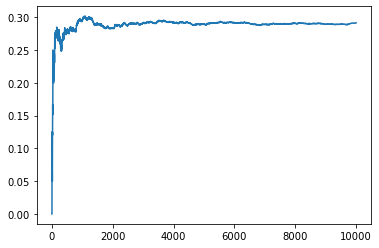

In [121]:
# we sample from our model. and calculate the current estimated probability
inp = [0,0,0,0,0,0,0,0]
estimate, history = random_sampling_binary(model,inp,10000)
display_prob_estimation(estimate,history,inp)

<function matplotlib.pyplot.show(*args, **kw)>

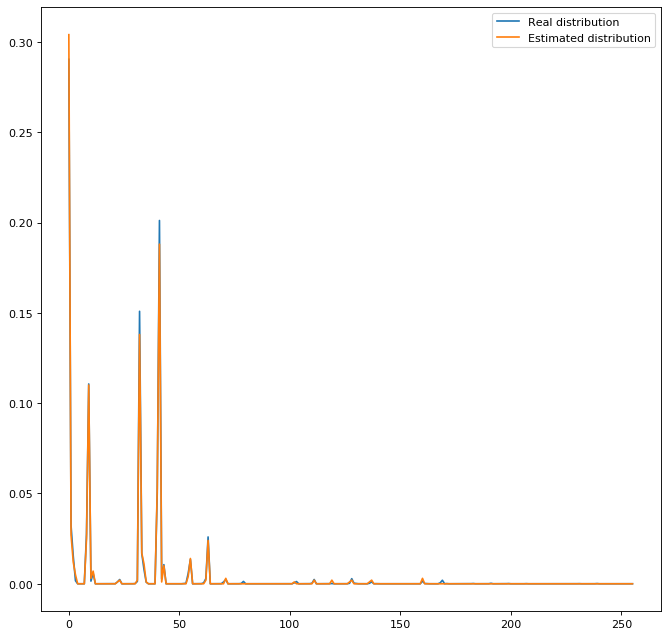

In [122]:
# compare the real prob distribution of events with the estimated distribution (Event = all variables are set)
possibilities = list(itertools.product([0,1],repeat = 8))
prob = 0
history1 = []
history2  = []
for state in possibilities:
    history1.append(interfere_specific_state(model,list(state)))
    estimate, history = random_sampling_binary(model,state,1000)
    history2.append(estimate)
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history1)
plt.plot(history2)
plt.legend(['Real distribution', 'Estimated distribution'])
plt.show

Real probability: 0.29036197574999995


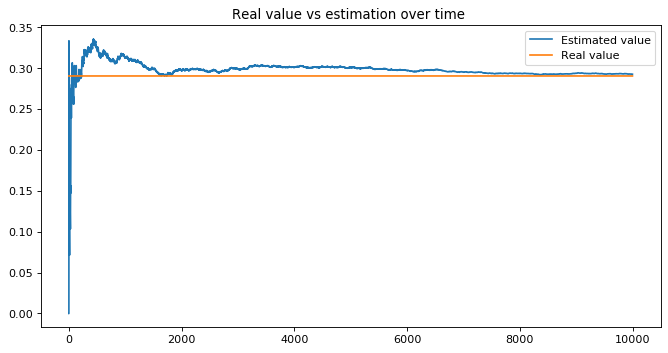

In [101]:
compare_specific_query(model,[0,0,0,0,0,0,0,0],10000)

Real probability: 0.31801549724999995


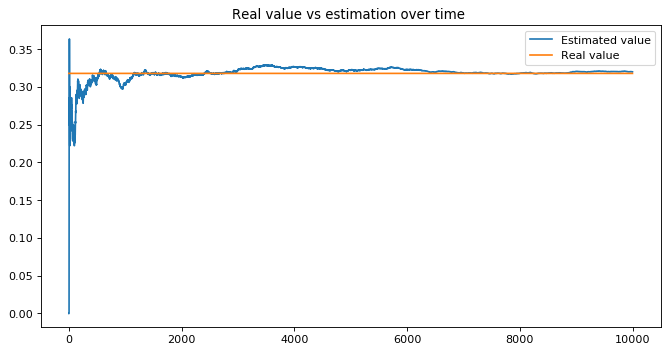

In [102]:
compare_specific_query(model,[0,None,0,0,None,0,0,0],10000)

Real probability: 0.00397575


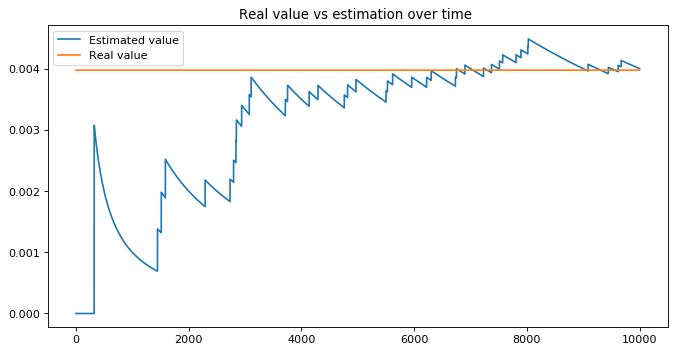

In [103]:
compare_specific_query(model,[1,None,None,None,1,0,None,None],10000)